<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Kaggle-Challenge/blob/master/module4/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.multiclass import unique_labels

In [0]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

In [0]:
random_state = 13

In [0]:
def get_years_since_construction(row):
  if 0 == row['construction_year']:
    return np.nan
  else:
    return row['year_recorded'] - row['construction_year']

In [0]:
def wrangle(dataframe):
    """Wrangles train, validate, and test sets in the same way"""
    df = dataframe.copy()

    # Convert date_recorded to datetime
    df['date_recorded'] = pd.to_datetime(df['date_recorded'], infer_datetime_format=True, errors='coerce')
    
    # Extract components from date_recorded, then drop the original column
    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month
    df['day_recorded'] = df['date_recorded'].dt.day
    df.drop(columns='date_recorded', inplace=True)
    
    # Engineer feature: how many years from construction_year to date_recorded
    df['years_since_construction'] = df[['year_recorded', 'construction_year']].apply(get_years_since_construction, axis=1)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df.drop(columns=unusable_variance, inplace=True)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group', 'quality_group', 'waterpoint_type_group', 'source_type', 'source_class', 'payment_type', 'management_group', 'extraction_type_group', 'extraction_type_class']
    df.drop(columns=duplicate_columns, inplace=True)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    df['latitude'] = df['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        
    return df

# Assignment

Plot a confusion matrix for your Tanzania Waterpumps model


Validation accuracy score: 80.35%




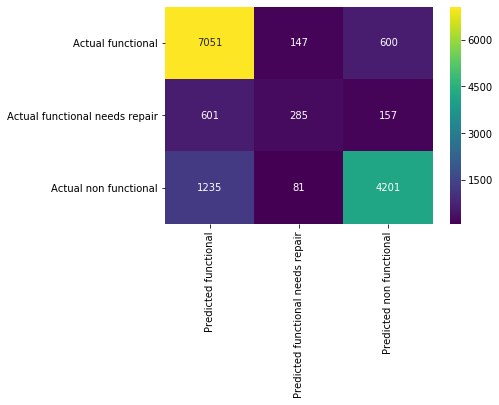

In [28]:
from sklearn.model_selection import train_test_split

target = 'status_group'
df_train, df_validate = train_test_split(train, test_size=len(test), stratify=train[target], random_state=random_state)

df_train, df_validate, df_test = map(wrangle, [df_train, df_validate, test])

features = df_train.columns.drop(target)

X_train = df_train[features]
X_validate = df_validate[features]
X_test = df_test[features]

y_train = df_train[target]
y_validate = df_validate[target]

pipeline = make_pipeline(
    ce.OneHotEncoder(cols=['basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type', 'management', 'payment',
                        'water_quality', 'quantity', 'source', 'waterpoint_type'],
                  drop_invariant=False, handle_missing='value',
                  handle_unknown='value', return_df=True, use_cat_names=True,
                  verbose=0),
    ce.OrdinalEncoder(cols=['funder', 'installer', 'wpt_name', 'subvillage', 'lga',
                        'ward', 'scheme_name'],
                  drop_invariant=False, handle_missing='value',
                  handle_unknown='value',
                  return_df=True, verbose=0),
    SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                  strategy='mean', verbose=0),
    RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                           criterion='gini', max_depth=None, max_features='auto',
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=70, n_jobs=-1, oob_score=False,
                           random_state=13, verbose=0, warm_start=False)
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_validate)
score = accuracy_score(y_validate, y_pred)
print(f'\nValidation accuracy score: {score * 100:.2f}%\n\n')

c_matrix = confusion_matrix(y_validate, y_pred)

labels = unique_labels(y_validate)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
table = pd.DataFrame(c_matrix, columns=columns, index=index)

sns.heatmap(table, annot=True, fmt='d', cmap='viridis')
plt.show()

# For Kaggle

In [8]:
df_train, df_test = map(wrangle, [train, test])
df_train.shape, df_test.shape

((59400, 33), (14358, 32))

In [0]:
target = 'status_group'

features = df_train.columns.drop([target])

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[target]

In [10]:
y_pred = [y_train.mode()[0]] * len(y_train)
baseline_majority_accuracy = accuracy_score(y_train, y_pred)
print(f'Baseline majority accuracy: {baseline_majority_accuracy * 100:.2f}%')

Baseline majority accuracy: 54.31%


In [0]:
cardinality = X_train.select_dtypes(exclude='number').nunique()
low_cardinality = cardinality[cardinality < 51].index.to_list()
high_cardinality = cardinality[cardinality > 50].index.to_list()

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(cols=low_cardinality, use_cat_names=True),
    ce.OrdinalEncoder(cols=high_cardinality),
    SimpleImputer(),
    RandomForestClassifier(random_state=random_state, n_jobs=-1,)
)

In [0]:
param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'simpleimputer__add_indicator' : [True, False],
    'randomforestclassifier__n_estimators' : [x for x in range(10, 101, 10)],
    'randomforestclassifier__class_weight' : ['balanced', 'balanced_subsample'],
    'randomforestclassifier__bootstrap' : [True, False],
    'randomforestclassifier__max_depth' : [None, 10, 20, 40, 80, 100],
    'randomforestclassifier__min_samples_split' : [2, 4, 8, 16, 32],
    'randomforestclassifier__min_samples_leaf' : [1, 10, 20]
}

In [0]:
search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=100, cv=5, n_jobs=-1, verbose=10)

In [17]:
search = search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.2min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 

In [19]:
best_pipeline = search.best_estimator_
for step in best_pipeline.named_steps:
  print(best_pipeline[step])
  print()

OneHotEncoder(cols=['basin', 'region', 'public_meeting', 'scheme_management',
                    'permit', 'extraction_type', 'management', 'payment',
                    'water_quality', 'quantity', 'source', 'waterpoint_type'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', return_df=True, use_cat_names=True,
              verbose=0)

OrdinalEncoder(cols=['funder', 'installer', 'wpt_name', 'subvillage', 'lga',
                     'ward', 'scheme_name'],
               drop_invariant=False, handle_missing='value',
               handle_unknown='value',
               mapping=[{'col': 'funder', 'data_type': dtype('O'),
                         'mapping': Roman                     1
Grumeti                   2
Lottery Club              3
Unicef                    4
Action In A               5
                       ... 
Cida                   1894
Dwe/anglican Church    1895
Dina                   1896
Brown                  1897
Saml

In [20]:
y_pred = best_pipeline.predict(X_test)
len(y_pred)

14358

In [22]:
file_name = 'submission.csv'

submission = sample_submission.copy()
submission['status_group'] = y_pred

submission.shape

(14358, 2)

In [23]:
submission.to_csv(file_name, index=False, header=True)
!head "$file_name"

id,status_group
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,non functional
